# Data Modelling

## Get the data from the previous notebook

In [60]:
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

USE_MERGED_DATA = True

#Get the data from the previous notebook, as csv files, and load them into dataframes
awards_players_df = pd.read_csv('../prep_data/awards_players_df.csv')
coaches_df = pd.read_csv('../prep_data/coaches_df.csv')
players_df = pd.read_csv('../prep_data/players_df.csv')
players_teams_df = pd.read_csv('../prep_data/players_teams_df.csv')
series_post_df = pd.read_csv('../prep_data/series_post_df.csv')
if USE_MERGED_DATA:
    teams_df = pd.read_csv('../prep_data/teams_df_with_sum_of_3_best_attributes_of_players.csv')
else:
    teams_df = pd.read_csv('../prep_data/teams_df.csv')
teams_post_df = pd.read_csv('../prep_data/teams_post_df.csv')

#make a dictionary with all the dataframes
dfs = {'awards_players_df': awards_players_df, 'coaches_df': coaches_df, 'players_df': players_df, 'players_teams_df': players_teams_df, 'series_post_df': series_post_df, 'teams_df': teams_df, 'teams_post_df': teams_post_df}


In [61]:
#Print all the dataframes
for key in dfs:
    print(key)
    print(dfs[key].head())
    print('\n')

awards_players_df
   year    playerID                               award
0     1  thompti01w  All-Star Game Most Valuable Player
1     2  leslili01w  All-Star Game Most Valuable Player
2     3  leslili01w  All-Star Game Most Valuable Player
3     4  teaslni01w  All-Star Game Most Valuable Player
4     6  swoopsh01w  All-Star Game Most Valuable Player


coaches_df
   year  stint  won  lost  post_wins  post_losses     coachID tmID
0     5      0   17    17          1            2  adamsmi01w  WAS
1     1      0   20    12          4            3  adubari99w  NYL
2     2      0   21    11          3            3  adubari99w  NYL
3     3      0   18    14          4            4  adubari99w  NYL
4     4      0   16    18          0            0  adubari99w  NYL


players_df
   firstseason  lastseason  num_seasons       bioID pos  height  weight  \
0            2           9            8  abrossv01w   F    74.0   169.0   
1            4           4            1  adamsjo01w   C    75.0   18

# MODELING

### Imports, constants and functions

In [62]:
#IMPORTS
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [63]:
#CONSTANTS

TARGET_NAMES = ['No Playoffs', 'Playoffs']
N_FOLDS_CV = 10

#see all null values in teams_df
teams_df.isnull().sum()

year                      0
confID                    0
playoff                   0
firstRound               62
semis                   104
finals                  122
o_fta                     0
o_3pm                     0
o_oreb                    0
o_asts                    0
o_stl                     0
o_to                      0
o_blk                     0
d_3pa                     0
d_oreb                    0
d_dreb                    0
d_asts                    0
d_stl                     0
d_to                      0
d_blk                     0
attend                    0
tmID                      0
W_post                   62
L_post                   62
num_seasons               0
height                    0
weight                    0
stint                     0
GP                        0
threeAttempted            0
dq                        0
PostoRebounds             0
PostBlocks                0
PostthreeAttempted        0
PostDQ                    0
FG%                 

In [64]:
def print_confusion_matrix(cm, target_names):
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def print_results(clf, X_train, X_test, y_train, y_test):
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Create a confusion matrix to evaluate the model and print with labels
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_matrix(cm, TARGET_NAMES)

    return y_pred

def cross_validation(clf, X, y):
    cv = StratifiedKFold(n_splits=N_FOLDS_CV, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Display the cross-validation results
    print("Cross-Validation Results:")
    print("Mean Accuracy: {:.2f}%".format(scores.mean() * 100))
    print("Standard Deviation: {:.2f}".format(scores.std()))

    return scores
    
def force_qualify_8_teams(y_pred, y_test):  
    top_teams_indices = y_pred.argsort()[-8:][::-1]  # Get the indices of the top 8 teams

    # Convert the labels to numeric format (0 for 'No Playoff', 1 for 'Playoff')
    y_pred_numeric = [1 if i in top_teams_indices else 0 for i in range(len(y_pred))]
    
    # Calculate the accuracy of the modified predictions
    accuracy = accuracy_score(y_test, y_pred_numeric)
    print("Modified Accuracy (Top 8 Teams as Playoff):", accuracy)
    
    # Create a confusion matrix to evaluate the model and print with labels
    cm = confusion_matrix(y_test, y_pred_numeric)
    print_confusion_matrix(cm, TARGET_NAMES)

## With current year info prediction

Run a simple model on the teams table to predict if a team will make it to the playoffs or not. Let's see how it behaves.

The main objective of this chapter is to find which is the model that performs the best, given the perfect data (the data from the year to be predicted)

In [65]:
# split into train years and test year (year 10)
teams_train_df = teams_df[teams_df['year'] < 10]
teams_test_df = teams_df[teams_df['year'] == 10]

cross_val_scores = []

### Random Forest

Accuracy: 1.0


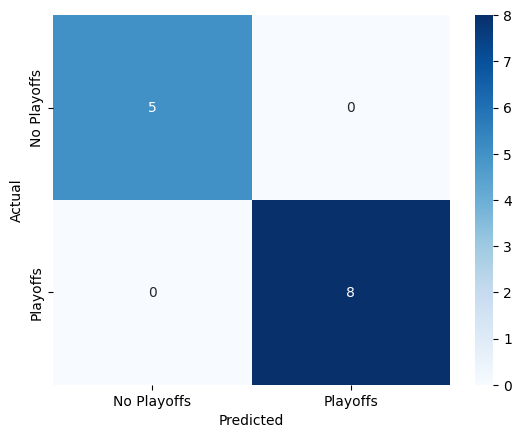

In [66]:
y_train = teams_train_df['playoff']
y_test = teams_test_df['playoff']
X_train = teams_train_df.drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)
X_test = teams_test_df.drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)

if USE_MERGED_DATA:
    X_train = X_train.drop(['W_post', 'L_post'], axis=1)
    X_test = X_test.drop(['W_post', 'L_post'], axis=1)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

clf = RandomForestClassifier()

y_pred = print_results(clf, X_train, X_test, y_train, y_test)

Modified Accuracy (Top 8 Teams as Playoff): 1.0


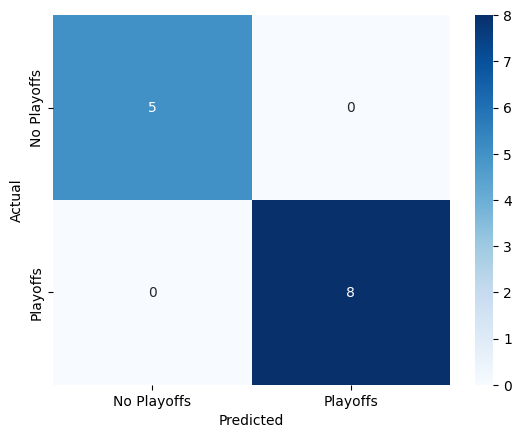

Cross-Validation Results:
Mean Accuracy: 100.00%
Standard Deviation: 0.00


In [67]:
force_qualify_8_teams(y_pred, y_test)

scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### KNN

Accuracy: 0.6153846153846154


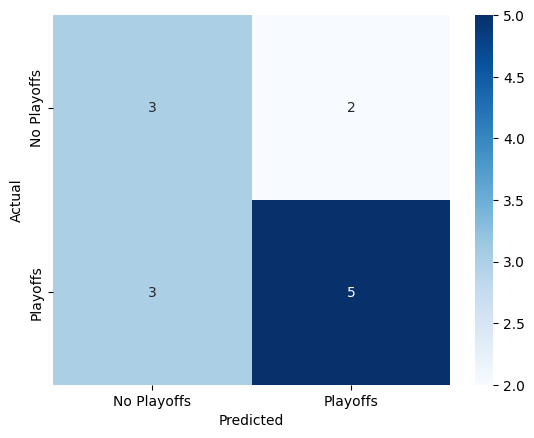

Modified Accuracy (Top 8 Teams as Playoff): 0.6923076923076923


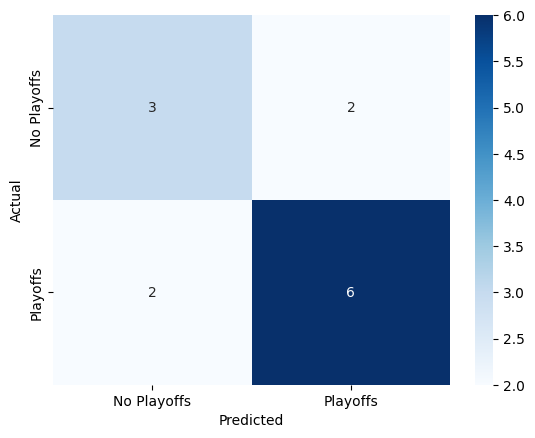

Cross-Validation Results:
Mean Accuracy: 57.76%
Standard Deviation: 0.08


In [68]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

y_pred = print_results(knn_classifier, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test)

scores = cross_validation(knn_classifier, X, y)
cross_val_scores.append(scores)

### Multinomial NaiveBayes

Accuracy: 0.6153846153846154


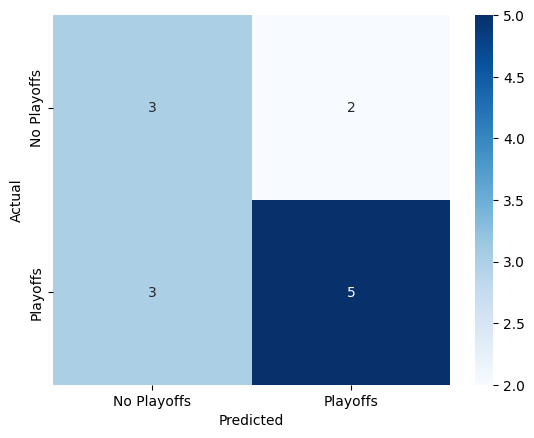

Modified Accuracy (Top 8 Teams as Playoff): 0.6923076923076923


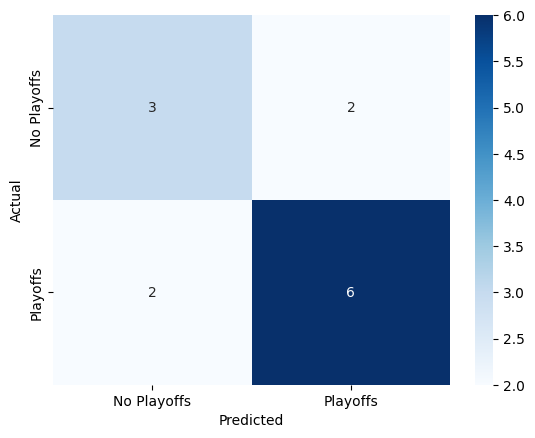

Cross-Validation Results:
Mean Accuracy: 95.00%
Standard Deviation: 0.07


In [69]:
mnb_classifier = MultinomialNB()

y_pred = print_results(knn_classifier, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test)

scores = cross_validation(mnb_classifier, X, y)
cross_val_scores.append(scores)

### Neural Network

Accuracy: 0.6153846153846154


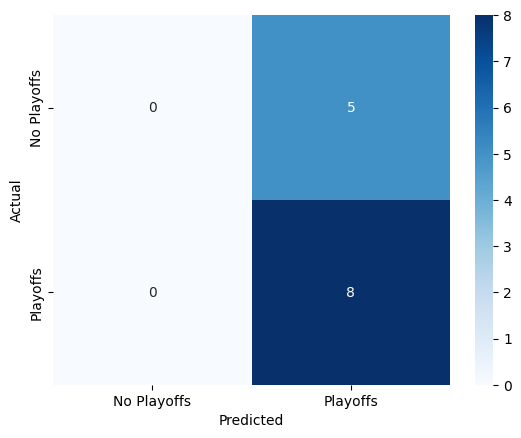

Modified Accuracy (Top 8 Teams as Playoff): 0.5384615384615384


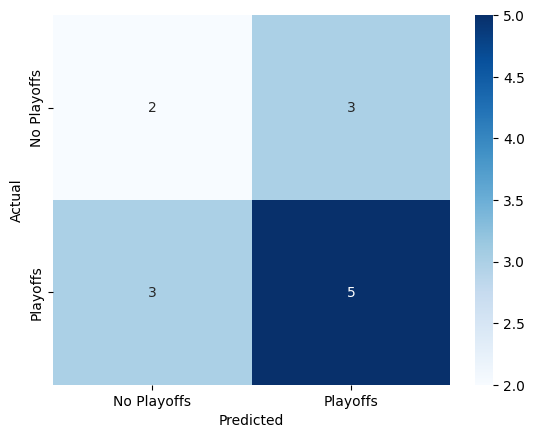

Cross-Validation Results:
Mean Accuracy: 47.86%
Standard Deviation: 0.07


In [70]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
    
y_pred = print_results(mlp_classifier, X_train, X_test, y_train, y_test)

force_qualify_8_teams(y_pred, y_test)

scores = cross_validation(mlp_classifier, X, y)
cross_val_scores.append(scores)

### Conclusions

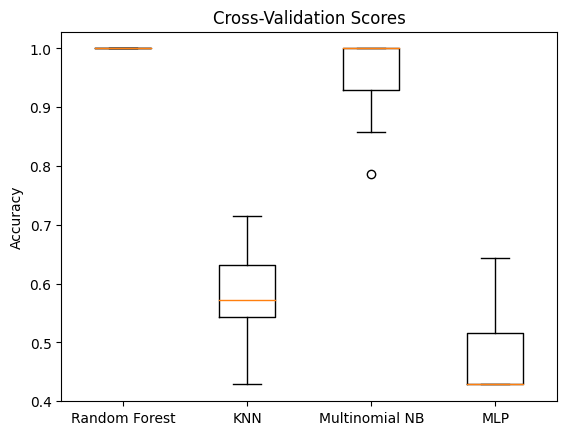

In [71]:
plt.boxplot(cross_val_scores, labels=['Random Forest', 'KNN', 'Multinomial NB', 'MLP'])
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy')
plt.show()

The Random Forest Classifier seems to be performing better than the other classifiers.

In the next chapter we will explore using a rolling window to use past years for the predictions

## Rolling window

### Rolling window functions

We will use a rolling window to predict the next season. We will use the last 3 seasons to predict the next one.

In [72]:
# Define the rolling window size (number of past years to consider)
ROLLING_WIN_SIZE = 3  # You can adjust this value
PREDICTION_YEAR = 10

historical_data_df = teams_df[teams_df['year'] < PREDICTION_YEAR]

def create_rolling_window_dataset(df, window_size):
    rolling_window_data = []
    for tmID, group in df.groupby('tmID'):
        group = group.sort_values(by='year')
        for i in range(len(group) - window_size + 1):
            window = group.iloc[i:i + window_size]
            rolling_window_data.append(window)
    return rolling_window_data

def generate_weights(window_size):
    weights = np.linspace(0.1, 1, window_size)
    weights /= weights.sum()  # Normalize weights to ensure they sum to 1
    return weights

Create the rolling window dataset.
In this dataset, three years are combined, with more weight given to the most recent year, and combining that historic data with the target variable (playoff) from the target year (the n+1 year)

In [73]:
# Create the rolling window datasets
rolling_window_historic = create_rolling_window_dataset(historical_data_df,  ROLLING_WIN_SIZE)

# Define weights (you can adjust these weights as needed)
weights = generate_weights(ROLLING_WIN_SIZE)

weighted_features = ['o_fta', 'o_3pm', 'o_oreb', 'o_asts', 'o_stl', 'o_to', 'o_blk', 'd_3pa', 'd_oreb', 'd_dreb', 'd_asts', 'd_stl', 'd_to', 'd_blk', 'attend']

if USE_MERGED_DATA:
    weighted_features += ['num_seasons', 'height', 'weight', 'stint', 'GP', 'threeAttempted', 'dq', 'PostoRebounds', 'PostBlocks', 'PostthreeAttempted', 'PostDQ', 'FG%', 'FT%', 'Avg_Assists_Per_Game', 'Avg_Blocks_Per_Game', 'Avg_Steals_Per_Game', 'Points_Ratio', 'POSITION_METRIC']

# Create a new dataframe to store the rolling window data
rolling_data = pd.DataFrame(columns=teams_df.columns)

for window in rolling_window_historic:
    #For each window, we will add a line to the rolling_data dataframe, as follows:
    #1. Create a new empty line for the rolling_data dataframe
    rolling_data_line = pd.DataFrame(columns=teams_df.columns)

    #2. Get the weighted average of the weighted features
    #Note: The weighted average is calculated as follows:
    #weighted average = sum of (weight * feature value) / sum of weights
    #For example, if the weights are [0.2, 0.3, 0.5] and the feature values are [10, 20, 30], then the weighted average is:
    #weighted average = (0.2 * 10 + 0.3 * 20 + 0.5 * 30) / (0.2 + 0.3 + 0.5) = 24
    for feature in weighted_features:
        weighted_average = np.average(window[feature].values, weights=weights)
        rolling_data_line[feature] = [weighted_average]

    #3. Join that data with the data from the following year (the year we want to predict)
    #Note: The data from the following year will be used as the target label, get next year from the teams_df dataframe
    next_year = window['year'].max() + 1
    next_year_data = teams_df[(teams_df['tmID'] == window['tmID'].values[0]) & (teams_df['year'] == next_year)]

    #Add year, confID, tmID, and playoff columns
    try:
        rolling_data_line['year'] = next_year
        rolling_data_line['tmID'] = window['tmID'].values[0]
        rolling_data_line['confID'] = next_year_data['confID'].values[0]
        rolling_data_line['playoff'] = next_year_data['playoff'].values[0]
    except:
        #If there is no data for the next year, skip this line
        #print('No data for next year')
        continue
    
    #4. Concat the data to the rolling_data dataframe
    rolling_data = pd.concat([rolling_data, rolling_data_line])

rolling_data = rolling_data.reset_index(drop=True)

### Random Forest with Rolling window

,confID,o_fta,o_3pm,o_oreb,o_asts,o_stl,o_to,o_blk,d_3pa,d_oreb,...,PostBlocks,PostthreeAttempted,PostDQ,FG%,FT%,Avg_Assists_Per_Game,Avg_Blocks_Per_Game,Avg_Steals_Per_Game,Points_Ratio,POSITION_METRIC
0,0,612.787879,186.818182,304.515152,489.666667,231.848485,435.333333,107.090909,374.090909,313.212121,...,10.090909,45.181818,0.0,1.522944,2.617083,11.323359,2.516821,4.425189,0.428313,9.631246
1,0,610.575758,192.939394,326.666667,496.060606,262.575758,465.939394,111.606061,393.030303,353.121212,...,6.363636,30.060606,0.606061,1.470021,2.601886,10.712292,2.554643,4.508801,0.405653,8.683117
2,0,594.424242,175.727273,287.454545,454.575758,234.878788,480.69697,125.909091,369.727273,369.575758,...,2.242424,10.151515,0.333333,1.460925,2.642269,9.190832,2.927605,3.611732,0.167003,8.69715
3,0,610.606061,129.69697,297.575758,471.030303,259.030303,514.030303,120.121212,346.454545,361.212121,...,0.363636,1.515152,0.060606,1.481698,2.651007,9.83604,2.844601,3.86722,0.02801,9.157716
5,0,538.030303,117.212121,297.848485,491.242424,238.636364,453.939394,83.484848,428.575758,284.272727,...,2.878788,12.848485,0.0,1.682467,2.590922,8.384516,1.795996,3.982828,0.470432,10.261499


Cross-Validation Results:
Mean Accuracy: 59.17%
Standard Deviation: 0.14
Accuracy: 0.5833333333333334


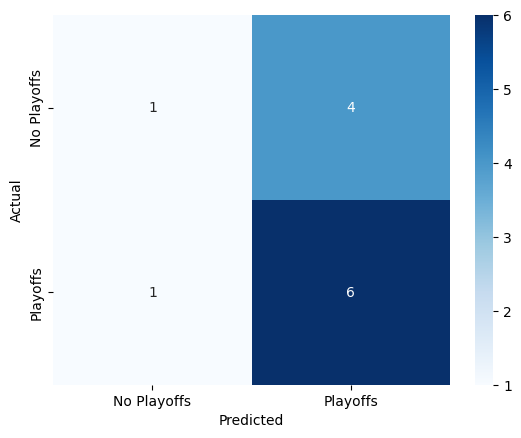

In [74]:
y_train = rolling_data[rolling_data['year'] < 10]['playoff'].astype(int)
y_test = rolling_data[rolling_data['year'] == 10]['playoff'].astype(int)
X_train = rolling_data[rolling_data['year'] < 10].drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)
X_test = rolling_data[rolling_data['year'] == 10].drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)

if USE_MERGED_DATA:
    X_train = X_train.drop(['W_post', 'L_post'], axis=1)
    X_test = X_test.drop(['W_post', 'L_post'], axis=1)

clf = RandomForestClassifier(n_estimators=100)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

display(X_train.head())

scores = cross_validation(clf, X, y)

y_pred = print_results(clf, X_train, X_test, y_train, y_test)

Modified Accuracy (Top 8 Teams as Playoff): 0.75


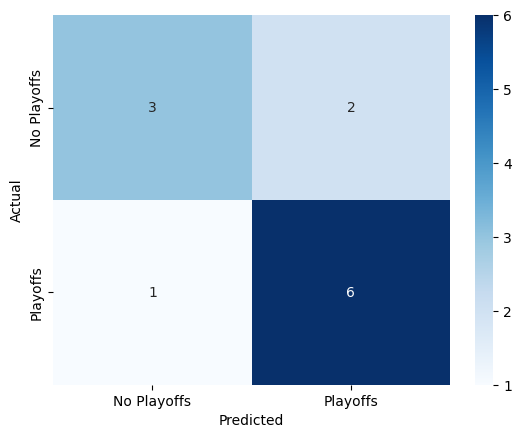

In [75]:
force_qualify_8_teams(y_pred, y_test)

## Grid Search

### Random Forest

Now, we will try to find what are the best parameters for the Random Forest, KNN and M Naive Bayes models, using Grid Search, and tune this models to see if we can improve the results.

In [83]:
#use grid search to find the best parameters
cross_val_scores = []
parameters = {'n_estimators': [10, 50, 100], 'max_depth': [9, 11, 13], 'max_features': ['sqrt', 'log2', 0.2], 'criterion': ['gini', 'entropy']}
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 50}
0.6914285714285714
RandomForestClassifier(max_depth=11, n_estimators=50)


Accuracy: 0.5833333333333334


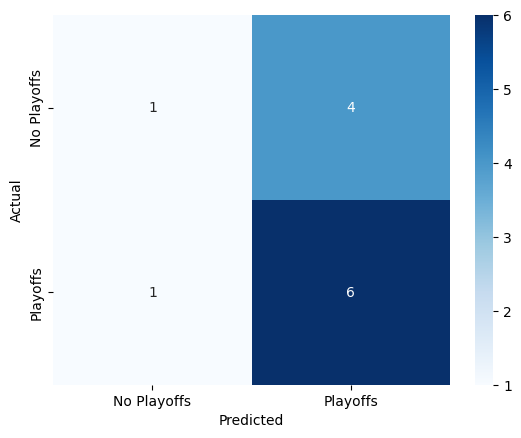

Modified Accuracy (Top 8 Teams as Playoff): 0.75


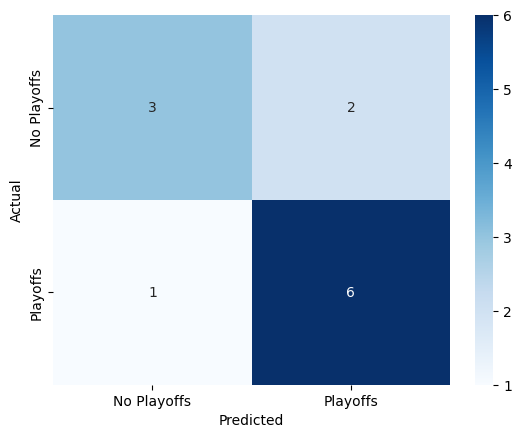

Cross-Validation Results:
Mean Accuracy: 67.36%
Standard Deviation: 0.08


In [84]:
#use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(y_pred, y_test)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### KNN

In [85]:
#use grid search to find the best parameters
parameters = {'n_neighbors': [3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']}
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'n_neighbors': 9, 'weights': 'uniform'}
0.7047619047619047
KNeighborsClassifier(n_neighbors=9)


Accuracy: 0.6666666666666666


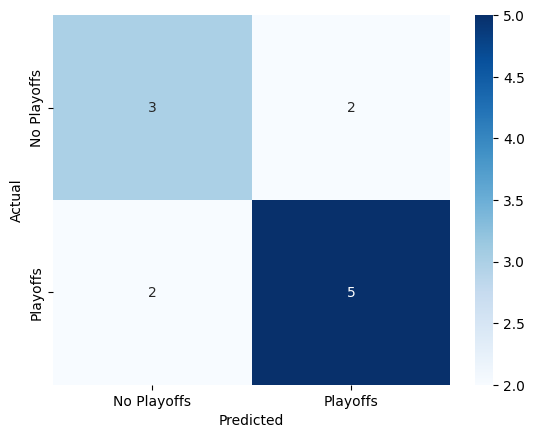

Modified Accuracy (Top 8 Teams as Playoff): 0.75


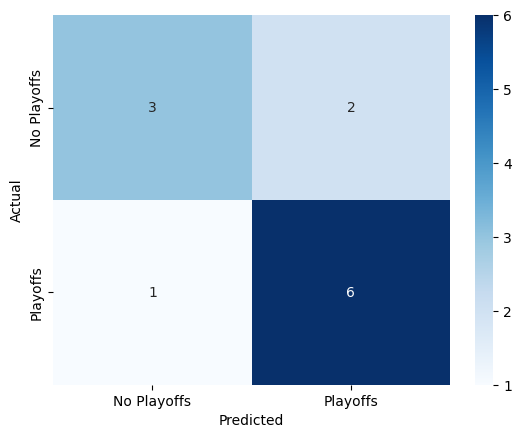

Cross-Validation Results:
Mean Accuracy: 69.72%
Standard Deviation: 0.15


In [86]:
#use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(y_pred, y_test)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### Multinomial NaiveBayes

In [87]:
#use grid search to find the best parameters
parameters = {'alpha': [0.1, 0.5, 1, 2, 5, 10]}
clf = MultinomialNB()
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'alpha': 10}
0.6333333333333334
MultinomialNB(alpha=10)


Accuracy: 0.6666666666666666


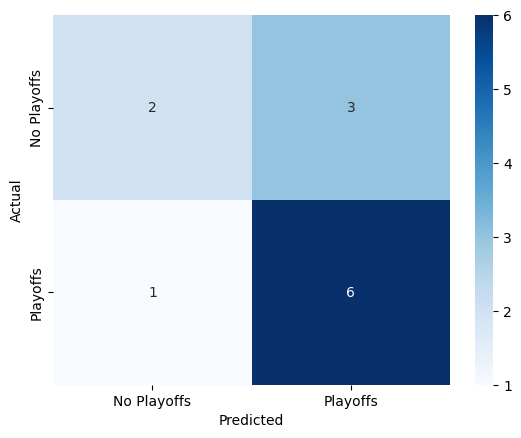

Modified Accuracy (Top 8 Teams as Playoff): 0.75


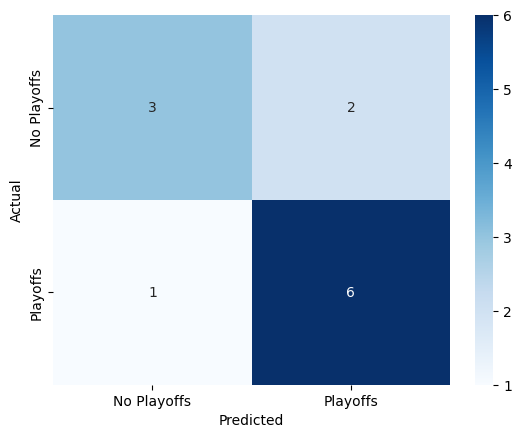

Cross-Validation Results:
Mean Accuracy: 55.14%
Standard Deviation: 0.14


In [88]:
#use the best parameters to train the model
y_pred = print_results(clf, X_train, X_test, y_train, y_test)
force_qualify_8_teams(y_pred, y_test)
scores = cross_validation(clf, X, y)
cross_val_scores.append(scores)

### Plotting the results

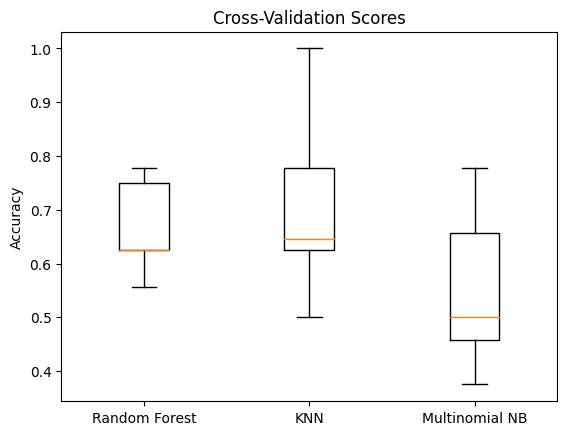

In [89]:
#plot the cross validation scores
plt.boxplot(cross_val_scores, labels=['Random Forest', 'KNN', 'Multinomial NB'])
plt.title('Cross-Validation Scores')
plt.ylabel('Accuracy') 
plt.show()